# Walk Forward Drift Adjusted Portfolio Optimization (DPO) vs. Mean-Variance Optimization

Empirical analysis of a new, novel portfolio optimization methodology created to be more robust out-of-sample: 

- Test is conducted by analyzing the efficacy of the universal DPO process vs. numerous constrained and unconstrained MVOs.
- Optimization methods are compared according to rebalancing frequency (i.e., 10, 20, & 60 trading day rebalancing frequencies).
- Optimization efficacy is determined based on: 
    - stability of performance across rebal_freqs
    - robustness to parameter tuning
    - implementability of portfolio weights
    - performance summary
- These are all implementable portfolios that exclusively use information prior to their rebalancing dates. Therefore, their outlined performance is reasonable to benchmark against each other and theoretically robust.
- One key advantage of DPO over MVO is its limited parameters and simplicity. There is no dependence on covaraince matrix estimation and inversion. 
- DPO maintains the ability to implement key constraints that portfolio managers may need (vol targeting, long-only, etc.) with the benefit of reducing the dimensionality of parameters. 

In [2]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import backtest_tools.portfolio_tools as pt

In [1]:
# Import Strategy Class
from dasr_optimized_portfolio_strategy_class import dasr_optimized_portfolio

Create Utility Functions

In [ ]:
from scipy.optimize import minimize
from scipy.optimize import Bounds
# -------------------------------------- Portfolio Optimization Functions --------------------------------------

def portfolio_dasr(w: pd.Series, returns: pd.DataFrame, neg = True) ->  float:
    """ Computes DASR of weighted portfolio.

    Args:
        betas (pd.Series): daily expected returns from normalized linear regression.
        squared_residuals (pd.DataFrame): squared error from OLS regression.
        w (pd.Series): portfolio weights.

    Returns:
        float: _description_
    """

    # Get weighted returns
    returns = (returns * w).sum(1)
    # Get weighted portfolio DASR
    portfolio_dasr = pt.drift_adjusted_sharpe_ratio(returns.dropna())

    if neg:
        # Return negative DASR for portfolio optimization
        return (-portfolio_dasr)
    
    # Return real DASR for performance analysis purposes
    return portfolio_dasr

def dpo_optimization(returns: pd.DataFrame, long_only=False, constrained=True, max_position_weight=1, vol_target=None) -> pd.Series:
    """ Executes constrained convex portfolio optimization to generate optimal
        DASR asset weights.

    Args:
        returns (pd.DataFrame): _description_
        long_only (bool, optional): _description_. Defaults to False.
        constrained (bool, optional): _description_. Defaults to True.
        max_position_weight (int, optional): _description_. Defaults to 1.
        vol_target (_type_, optional): _description_. Defaults to None.

    Returns:
        pd.Series: _description_
    """

    n = len(returns.columns)

    # Initial guess is naive 1/n portfolio
    w = np.array([1 / n] * n)

    # Declare constraints list
    constraints =  []

    # Set constraints (e.g., leverage, vol target, max sizing)
    if constrained:

        # Max position size
        if long_only:
            # Long only constraint
            bounds = Bounds(0, max_position_weight)
        else:
            # L/S constraint
            bounds = Bounds(-max_position_weight, max_position_weight)

        # constraints =  [# Weights Constraint
        #         {"type": "eq", "fun": lambda w: np.sum(np.abs(w)) - 1},
        #         # {"type": "eq", "fun": lambda w: np.sum(w) - 0},
        #         ]
        # No Leverage Constraint
        constraints.append({"type": "eq", "fun": lambda w: np.sum(np.abs(w)) - 1})

        # Volatility Targeting
        if vol_target is not None:           
            constraints.append({"type": "eq", "fun": lambda w: np.sqrt(np.dot(np.dot(w.T, returns.cov()), w)) - vol_target})
    else:
        # Is not implementable nor optimal
        bounds = Bounds(-100, 100)

        constraints =  []
    
    # Get optimized weights
    w = pd.Series(minimize(portfolio_dasr, 
                            w,
                            args=(returns), 
                            method='SLSQP',
                            bounds = bounds,
                            constraints=constraints)['x'],
                index=returns.columns
                )
    
    return w

def multistrategy_portfolio_optimization(multistrategy_portfolio: pd.DataFrame, rebal_freq: int, lookback_window: int, optimization = ['MVO', 'DPO'], vol_target=None, max_position_weight=.2, constrained=True):
    """ Executes multistrategy portfolio optimization by leveraging either one of two different optimization algorithms: 
        - MVO
        - Drift Adjusted Portfolio Optimization

    Args:
        multistrategy_portfolio (pd.DataFrame): strategy returns.
        rebal_freq (int):
        lookback_window (int): 
        optimiztion (list, optional): type of optimization. Defaults to ['MVO', 'DPO'].
        vol_target (float, optional): Defaults to .01.
        max_position_weight (float, optional): Defaults to .5.
        constrained (boolean, optiona;): 
    """

    w = {}

    if optimization == 'MVO':
        for date in multistrategy_portfolio.index[::rebal_freq]:
        
            w[date] = pt.mvo(hist_returns=multistrategy_portfolio.loc[:date], expected_returns=multistrategy_portfolio.loc[:date].tail(lookback_window).mean(), vol_target=vol_target, max_position_weight=max_position_weight, constrained=constrained, verbose=False, long_only=True)
    
    elif optimization == 'DPO':
        for date in multistrategy_portfolio.index[::rebal_freq]:
            w[date] = dpo_optimization(returns=multistrategy_portfolio.loc[:date].tail(lookback_window), long_only=True, constrained=constrained, max_position_weight=max_position_weight, vol_target=vol_target)

    # Convert Hash Table to DataFrame
    indices_df = pd.DataFrame(index=multistrategy_portfolio.index)
    w = pd.concat([indices_df, pd.DataFrame(w).T], axis=1).ffill().dropna()

    # Get strategy returns
    multistrategy_portfolio_optimized_returns = (multistrategy_portfolio*w.shift(2)).sum(1).dropna()

    return multistrategy_portfolio_optimized_returns, w

    

Visualize Individual Strategy

20
['SPY', 'QQQ', 'DBC', 'TLT', 'GLD']


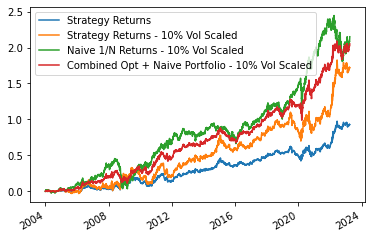

10
['SPY', 'QQQ', 'DBC', 'TLT', 'GLD']


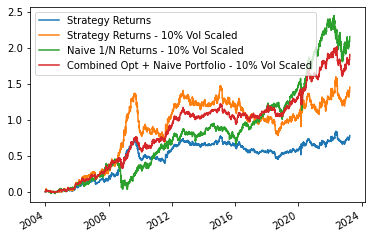

20
['SPY', 'QQQ', 'GLD', 'TLT', 'DBC', 'XLE', 'EEM']


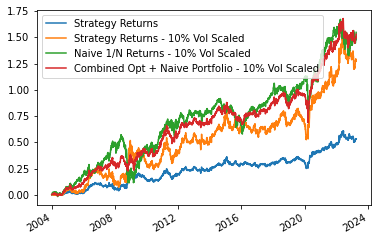

10
['SPY', 'QQQ', 'GLD', 'TLT', 'DBC', 'XLE', 'EEM']


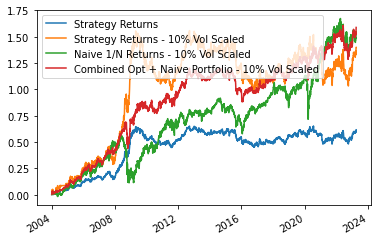

20
['SPY', 'GLD', 'TLT', 'DBC', 'JNK', 'EEM']


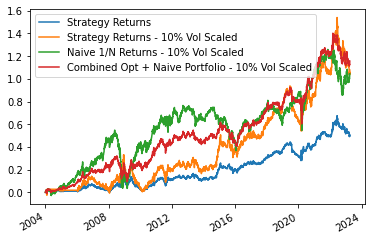

10
['SPY', 'GLD', 'TLT', 'DBC', 'JNK', 'EEM']


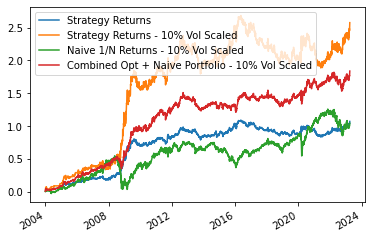

20
['SPY', 'QQQ', 'TLT', 'DBC']


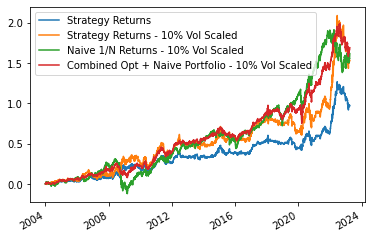

10
['SPY', 'QQQ', 'TLT', 'DBC']


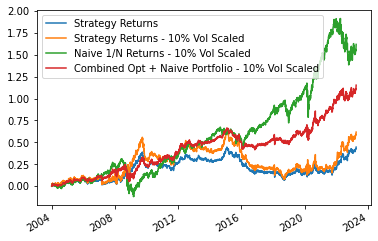

In [ ]:
for i in range(0, 8):

    path = fr'C:\Users\marcu\Documents\Quant\Programming\Strategies\Beta Strategies\dasr_optimized_portfolio_strategy_{i}.pickle'
    
    with open(path, 'rb') as handler:
        strategy = pickle.load(handler)
        print(strategy.rebal_freq)
        strategy.performance_analysis()
        plt.show()

# Create Multistrategy Portfolio

In [ ]:
multistrategy_portfolio = {}

for i in range(0, 7):

    path = fr'C:\Users\marcu\Documents\Quant\Programming\Strategies\Beta Strategies\dasr_optimized_portfolio_strategy_{i}.pickle'
    
    with open(path, 'rb') as handler:
        strategy = pickle.load(handler)
        multistrategy_portfolio[i] = strategy.strategy_returns

    i+=1

multistrategy_portfolio = pd.DataFrame(multistrategy_portfolio)

In [ ]:
import datetime as dt

# Isolate portfolio returns post-2004
multistrategy_portfolio = multistrategy_portfolio.loc[dt.date(2004, 1, 1):]

# Walk Forward Drift Adjusted Portfolio Optimization (DPO) vs. Mean-Variance Optimization

- Test is conducted by analyzing the efficacy of the universal DPO process vs. numerous constrained and unconstrained MVOs.
- Optimization methods are compared according to rebalancing frequency (i.e., 10, 20, & 60 trading day rebalancing frequencies).
- Optimization efficacy is determined based on: 
    - stability of performance across rebal_freqs
    - robustness to parameter tuning
    - implementability of portfolio weights
    - performance summary
- These are all implementable portfolios that exclusively use information prior to their rebalancing dates. Therefore, their outlined performance is reasonable to benchmark against each other and theoretically robust.

In [ ]:
# Create optimizations for 20 day rebal
rebal_freq = 20
lookback_window = 20
multistrategy_portfolio_dpo_1, dpo_w_1 = multistrategy_portfolio_optimization(multistrategy_portfolio=multistrategy_portfolio, rebal_freq=rebal_freq, lookback_window=lookback_window, optimiztion = 'DPO')
print('DPO 1 DONE')
multistrategy_portfolio_mvo_1, mvo_w_1 = multistrategy_portfolio_optimization(multistrategy_portfolio=multistrategy_portfolio, rebal_freq=rebal_freq, lookback_window=lookback_window, optimiztion = 'MVO', vol_target=.01, max_position_weight=.5)
multistrategy_portfolio_mvo_2, mvo_w_2 = multistrategy_portfolio_optimization(multistrategy_portfolio=multistrategy_portfolio, rebal_freq=rebal_freq, lookback_window=lookback_window, optimiztion = 'MVO', vol_target=.01, max_position_weight=3)
multistrategy_portfolio_mvo_3, mvo_w_3 = multistrategy_portfolio_optimization(multistrategy_portfolio=multistrategy_portfolio, rebal_freq=rebal_freq, lookback_window=lookback_window, optimiztion = 'MVO', vol_target=.1, max_position_weight=.5)
multistrategy_portfolio_mvo_4, mvo_w_4 = multistrategy_portfolio_optimization(multistrategy_portfolio=multistrategy_portfolio, rebal_freq=rebal_freq, lookback_window=lookback_window, optimiztion = 'MVO', vol_target=.1, max_position_weight=3)
multistrategy_portfolio_mvo_uncon_1, mvo_w_uncon_1 = multistrategy_portfolio_optimization(multistrategy_portfolio=multistrategy_portfolio, rebal_freq=rebal_freq, lookback_window=lookback_window, optimiztion = 'MVO', constrained=False)

# Create optimizations for 10 day rebal
rebal_freq = 10
lookback_window = 10
multistrategy_portfolio_dpo_2, dpo_w_2 = multistrategy_portfolio_optimization(multistrategy_portfolio=multistrategy_portfolio, rebal_freq=rebal_freq, lookback_window=lookback_window, optimiztion = 'DPO')
print('DPO 2 DONE')
multistrategy_portfolio_mvo_5, mvo_w_5 = multistrategy_portfolio_optimization(multistrategy_portfolio=multistrategy_portfolio, rebal_freq=rebal_freq, lookback_window=lookback_window, optimiztion = 'MVO', vol_target=.01, max_position_weight=.5)
multistrategy_portfolio_mvo_6, mvo_w_6 = multistrategy_portfolio_optimization(multistrategy_portfolio=multistrategy_portfolio, rebal_freq=rebal_freq, lookback_window=lookback_window, optimiztion = 'MVO', vol_target=.01, max_position_weight=3)
multistrategy_portfolio_mvo_7, mvo_w_7 = multistrategy_portfolio_optimization(multistrategy_portfolio=multistrategy_portfolio, rebal_freq=rebal_freq, lookback_window=lookback_window, optimiztion = 'MVO', vol_target=.1, max_position_weight=.5)
multistrategy_portfolio_mvo_8, mvo_w_8 = multistrategy_portfolio_optimization(multistrategy_portfolio=multistrategy_portfolio, rebal_freq=rebal_freq, lookback_window=lookback_window, optimiztion = 'MVO', vol_target=.1, max_position_weight=3)
multistrategy_portfolio_mvo_uncon_2, mvo_w_uncon_2 = multistrategy_portfolio_optimization(multistrategy_portfolio=multistrategy_portfolio, rebal_freq=rebal_freq, lookback_window=lookback_window, optimiztion = 'MVO', constrained=False)

# Create optimizations for 60 day rebal
rebal_freq = 60
lookback_window = 60
multistrategy_portfolio_dpo_3, dpo_w_3 = multistrategy_portfolio_optimization(multistrategy_portfolio=multistrategy_portfolio, rebal_freq=rebal_freq, lookback_window=lookback_window, optimiztion = 'DPO')
print('DPO 3 DONE')
multistrategy_portfolio_mvo_9, mvo_w_9 = multistrategy_portfolio_optimization(multistrategy_portfolio=multistrategy_portfolio, rebal_freq=rebal_freq, lookback_window=lookback_window, optimiztion = 'MVO', vol_target=.01, max_position_weight=.5)
multistrategy_portfolio_mvo_10, mvo_w_10 = multistrategy_portfolio_optimization(multistrategy_portfolio=multistrategy_portfolio, rebal_freq=rebal_freq, lookback_window=lookback_window, optimiztion = 'MVO', vol_target=.01, max_position_weight=3)
multistrategy_portfolio_mvo_11, mvo_w_11 = multistrategy_portfolio_optimization(multistrategy_portfolio=multistrategy_portfolio, rebal_freq=rebal_freq, lookback_window=lookback_window, optimiztion = 'MVO', vol_target=.1, max_position_weight=.5)
multistrategy_portfolio_mvo_12, mvo_w_12 = multistrategy_portfolio_optimization(multistrategy_portfolio=multistrategy_portfolio, rebal_freq=rebal_freq, lookback_window=lookback_window, optimiztion = 'MVO', vol_target=.1, max_position_weight=3)
multistrategy_portfolio_mvo_uncon_3, mvo_w_uncon_3 = multistrategy_portfolio_optimization(multistrategy_portfolio=multistrategy_portfolio, rebal_freq=rebal_freq, lookback_window=lookback_window, optimiztion = 'MVO', constrained=False)               

DPO 1 DONE


C:\Users\marcu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\pandas\core\frame.py:9525: RuntimeWarning: Degrees of freedom <= 0 for slice
  base_cov = np.cov(mat.T, ddof=ddof)
C:\Users\marcu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\numpy\lib\function_base.py:2542: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
C:\Users\marcu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\numpy\lib\function_base.py:2542: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
C:\Users\marcu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\pandas\core\frame.py:9525: RuntimeWarning: Degrees of freedom <= 0 for slice
  base_cov = np.cov(

DPO 2 DONE


C:\Users\marcu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\pandas\core\frame.py:9525: RuntimeWarning: Degrees of freedom <= 0 for slice
  base_cov = np.cov(mat.T, ddof=ddof)
C:\Users\marcu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\numpy\lib\function_base.py:2542: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
C:\Users\marcu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\numpy\lib\function_base.py:2542: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
C:\Users\marcu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\pandas\core\frame.py:9525: RuntimeWarning: Degrees of freedom <= 0 for slice
  base_cov = np.cov(

DPO 3 DONE


C:\Users\marcu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\pandas\core\frame.py:9525: RuntimeWarning: Degrees of freedom <= 0 for slice
  base_cov = np.cov(mat.T, ddof=ddof)
C:\Users\marcu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\numpy\lib\function_base.py:2542: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
C:\Users\marcu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\numpy\lib\function_base.py:2542: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
C:\Users\marcu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\pandas\core\frame.py:9525: RuntimeWarning: Degrees of freedom <= 0 for slice
  base_cov = np.cov(

Cateogrize Optimization Methods' Returns 

In [2]:
dpo = [multistrategy_portfolio_dpo_1, multistrategy_portfolio_dpo_2, multistrategy_portfolio_dpo_3]
mvo = [multistrategy_portfolio_mvo_1, multistrategy_portfolio_mvo_2, multistrategy_portfolio_mvo_3, multistrategy_portfolio_mvo_4, multistrategy_portfolio_mvo_5, multistrategy_portfolio_mvo_6, multistrategy_portfolio_mvo_7, 
       multistrategy_portfolio_mvo_8, multistrategy_portfolio_mvo_9, multistrategy_portfolio_mvo_10, multistrategy_portfolio_mvo_11, multistrategy_portfolio_mvo_12]
uncon_mvo = [multistrategy_portfolio_mvo_uncon_1, multistrategy_portfolio_mvo_uncon_2, multistrategy_portfolio_mvo_uncon_2]

Compute Performance Metrics

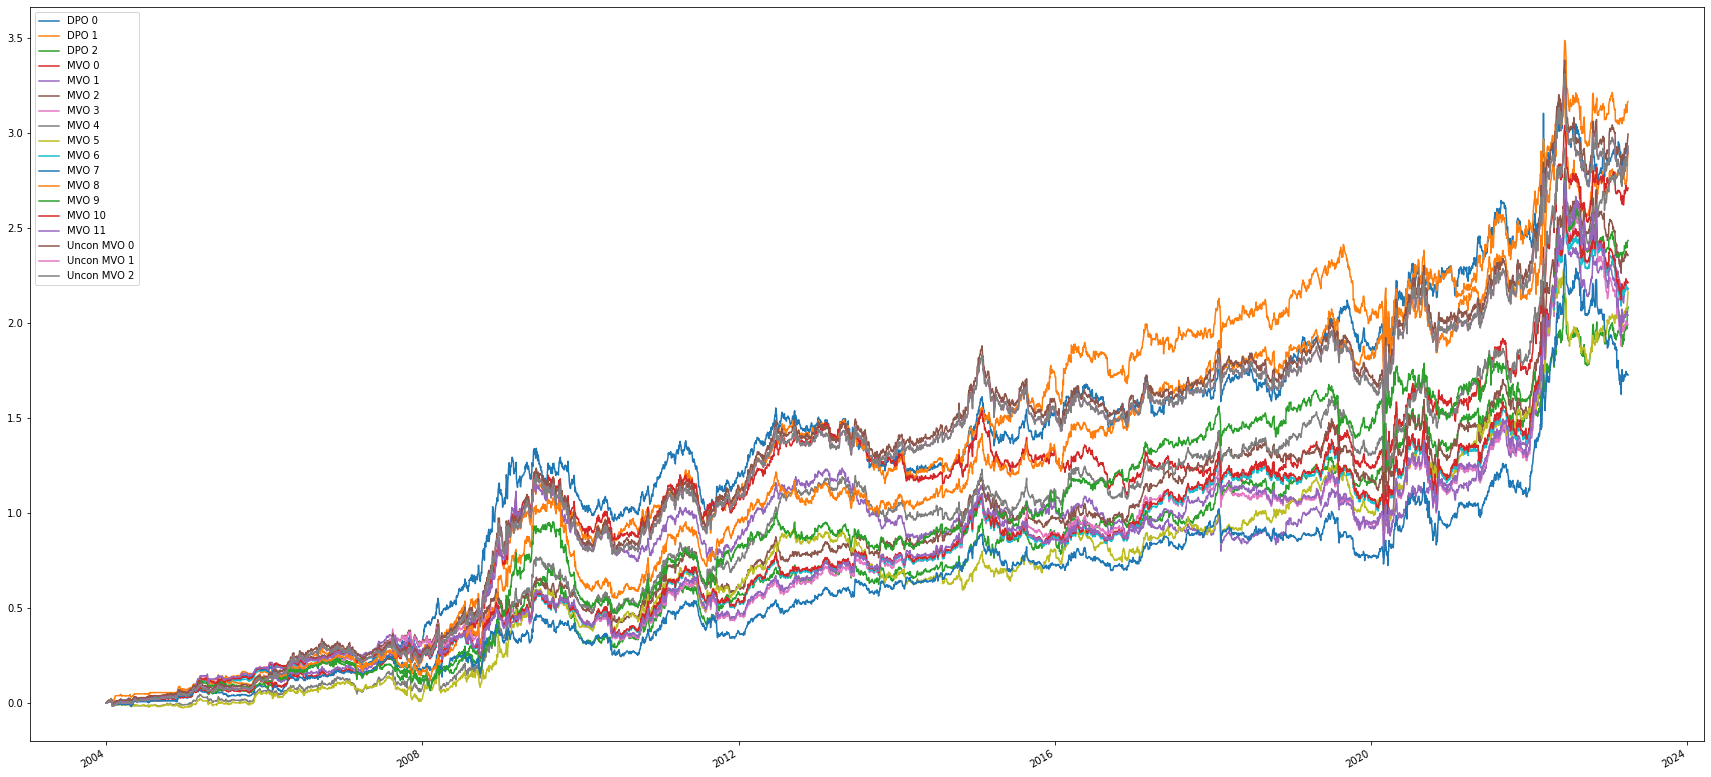

In [ ]:
plt.figure(figsize=(30, 15))

# Drift Adjusted Portfolio Optimization
dpo_performance = pd.DataFrame()

for i, p_rets in enumerate(dpo):
    # Scale returns
    tmp_rets = pt.scale_vol(p_rets)
    # Plot cumulative returns
    pt.cumulative_returns(tmp_rets).plot(label=f'DPO {i}', legend=True)
    # Add strategy to DPO pd.DataFrame
    dpo_performance = pd.concat([pt.performance_summary(tmp_rets), dpo_performance], axis=1)

# Compute average performance metrics across optimization implementations
dpo_performance = dpo_performance.mean(axis=1)

# Constrained MVO
mvo_performance = pd.DataFrame()

for i, p_rets in enumerate(mvo):
    # Scale returns
    tmp_rets = pt.scale_vol(p_rets)
    # Plot cumulative returns
    pt.cumulative_returns(tmp_rets).plot(label=f'MVO {i}', legend=True)
    # Add strategy to DPO pd.DataFrame
    mvo_performance = pd.concat([pt.performance_summary(tmp_rets), mvo_performance], axis=1)

# Compute average performance metrics across optimization implementations
mvo_performance = mvo_performance.mean(axis=1)

# Unconstrained MVO (never implementable)
uncon_mvo_performance = pd.DataFrame()

for i, p_rets in enumerate(uncon_mvo):
    # Scale returns
    tmp_rets = pt.scale_vol(p_rets)
    # Plot cumulative returns
    pt.cumulative_returns(tmp_rets).plot(label=f'Uncon MVO {i}', legend=True)
    # Add strategy to DPO pd.DataFrame
    uncon_mvo_performance = pd.concat([pt.performance_summary(tmp_rets), uncon_mvo_performance], axis=1)
    
# Compute average performance metrics across optimization implementations
uncon_mvo_performance = uncon_mvo_performance.mean(axis=1)

In [ ]:
# Get comparative performance
average_optimization_performance = pd.concat([dpo_performance, mvo_performance, uncon_mvo_performance], axis=1)
average_optimization_performance.columns = ['DPO', 'MVO', 'Uncon MVO']
average_optimization_performance

,DPO,MVO,Uncon MVO
Sharpe Ratio,0.717333,0.673833,0.764667
Drift Adjusted Sharpe Ratio,14.483667,6.562750,11.037667
CAGR,0.068667,0.064583,0.074333
Vol,0.100000,0.100000,0.100000
Sortino Ratio,0.967000,0.885083,1.035667
Martin (Ulcer) Ratio,1.164333,1.028417,1.105667
Omega Ratio,1.007333,0.999417,1.016333
RR Ratio,1.141667,1.137000,1.150667
Win Rate,0.527667,0.527250,0.531000
Skew,-0.069667,-0.057417,-0.027333


Apply DPO algorithm without without max position sizing bounds, but no leverage (i.e., any given position can have 100% weight at any given point, but more than that)

In [ ]:
rebal_freq = 10
lookback_window = 10
multistrategy_portfolio_dpo, dpo_w = multistrategy_portfolio_optimization(multistrategy_portfolio=multistrategy_portfolio, rebal_freq=rebal_freq, lookback_window=lookback_window, optimization = 'DPO', max_position_weight=1)
print('DPO 1 DONE')

DPO 1 DONE


- As we can see, the DPO algorithm performs extremely meaningfully better than any other previously explored methods.
- DPO outperforms in every metric, ranging from Kurtosis to Martin Ratio. It is clear that it is highly effective at capturing "factor momentum" / statistically significant trends


,Performance Summary
Sharpe Ratio,0.823
Drift Adjusted Sharpe Ratio,13.361
CAGR,0.080
Vol,0.100
Sortino Ratio,1.094
Martin (Ulcer) Ratio,1.410
Omega Ratio,1.027
RR Ratio,1.165
Win Rate,0.527
Skew,-0.166


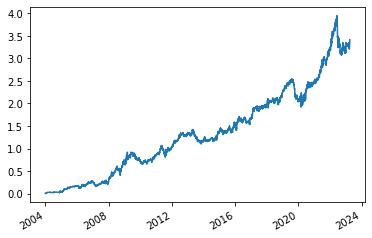

In [ ]:
pt.cumulative_returns(pt.scale_vol(multistrategy_portfolio_dpo)).plot()
pt.performance_summary(pt.scale_vol(multistrategy_portfolio_dpo))